<a href="https://colab.research.google.com/github/visgraf/labipcv/blob/main/notebooks/BaseGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on [Diego Alejo's implementation](https://github.com/diegoalejogm/gans/blob/master/utils.py)

In [ ]:
%load_ext autoreload
%matplotlib inline

In [ ]:
%autoreload 2

from IPython import display

import torch
import matplotlib.pyplot as plt
import os
import pickle

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/workspace/MNIST'

## Load Data

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [ ]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Networks

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
generator_in_features = 100
torch.manual_seed(777)

In [ ]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = generator_in_features
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, generator_in_features))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [ ]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Optimization

In [ ]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

## Training

In [ ]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [ ]:
# Visualization
def log_images(test_images, savepath):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  rows, cols = len(test_images)//4, 4
  for i, img in enumerate(test_images):
      figure.add_subplot(rows, cols, i+1)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap='gray')  
  
  figure.savefig(savepath)
  plt.show()

In [ ]:
def save_models(generator, discriminator, epoch, folder):
  torch.save(generator, os.path.join(folder, f"generator_e{epoch}.pth"))
  torch.save(discriminator, os.path.join(folder, f"discriminator_e{epoch}.pth"))

def load_models(epoch, folder):
  generator = torch.load(os.path.join(folder, f"generator_e{epoch}.pth"))
  discriminator = torch.load(os.path.join(folder, f"discriminator_e{epoch}.pth"))
  return generator, discriminator

def save_losses(g_loss, d_loss, epoch, folder):
  with open(os.path.join(folder, f"gloss_{epoch}.pickle"), 'wb') as f:
    pickle.dump(g_loss, f)
  with open(os.path.join(folder, f"dloss_e{epoch}.pickle"), 'wb') as f:
    pickle.dump(d_loss, f)

def load_models(epoch, folder):
  with open(os.path.join(folder, f"gloss_{epoch}.pickle"), 'rb') as f:
    g_loss = pickle.load(f)
  with open(os.path.join(folder, f"dloss_e{epoch}.pickle"), 'rb') as f:
    d_loss = pickle.load(f)
  return g_loss, d_loss

### Generate Samples for Testing

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

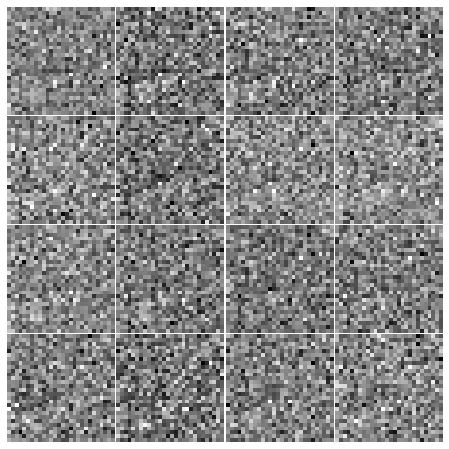

In [ ]:
imagepath = os.path.join(DATA_FOLDER, 'results', f'{0}.jpg')
log_images(vectors_to_images(generator(test_noise)).cpu().detach().numpy(), 
           imagepath)

### Start training

In [ ]:
D_losses = []
G_losses = []
# if we are resuming the training
last_epoch = 0
if last_epoch > 0:
  folder = os.path.join(DATA_FOLDER, 'models')
  generator, discriminator = load_models(last_epoch, folder)
  G_losses, D_losses = load_losses(last_epoch, folder)

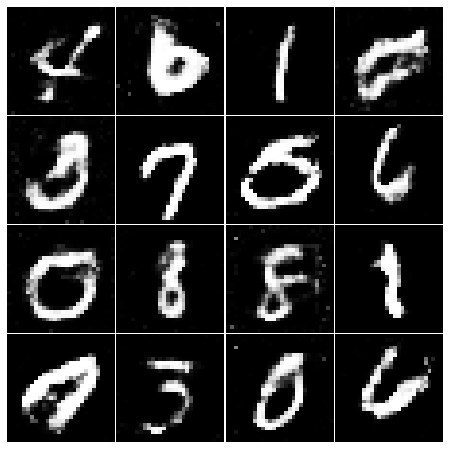

Epoch: 199/100 Losses:
Discriminator: 1.29; Generator: 0.89
D(x): 0.60; D(G(z)): 0.48


In [ ]:
for epoch in range(100, 200):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
    display.clear_output(True)
    # Show generated images
    imagepath = os.path.join(DATA_FOLDER, 'results', f'{epoch+1}.jpg')
    test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
    log_images(test_images, imagepath)
    # Display statu s Logs
    print(f"Epoch: {epoch}/{num_epochs} Losses:")
    print(f"Discriminator: {d_error:.2f}; Generator: {g_error:.2f}")
    print(f"D(x): {d_pred_real.mean():.2f}; D(G(z)): {d_pred_fake.mean():.2f}")
    G_losses.append(g_error)
    D_losses.append(d_error)
    if epoch % 10 == 0:
        # Save model checkpoints
        folder = os.path.join(DATA_FOLDER, 'models')
        save_models(generator, discriminator, epoch, folder) 
        save_losses(G_losses, D_losses, epoch, folder)

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

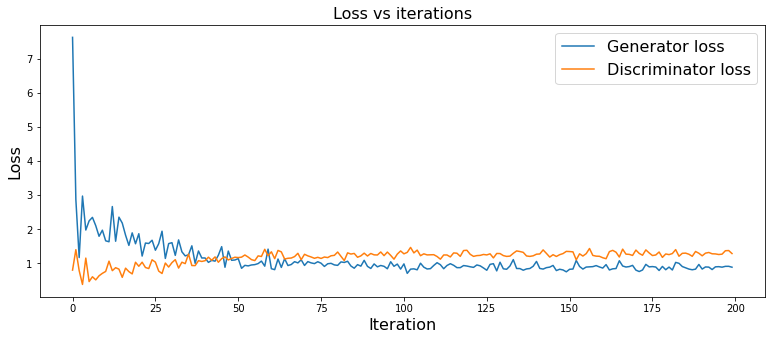

In [ ]:
losses = {"Generator loss": G_losses, "Discriminator loss": D_losses}
plot_losses(losses)

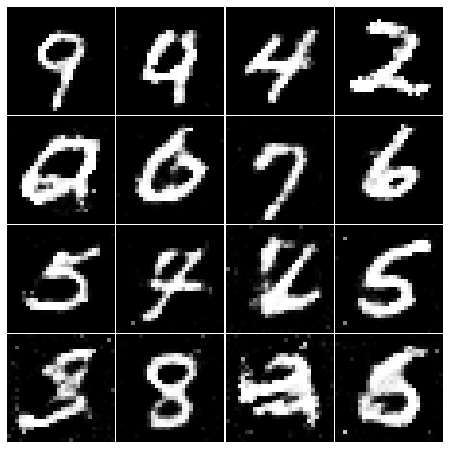

In [ ]:
imagepath = os.path.join(DATA_FOLDER, 'results', f'teste.jpg')
log_images(vectors_to_images(generator(noise(16))).cpu().detach().numpy(), 
           imagepath)

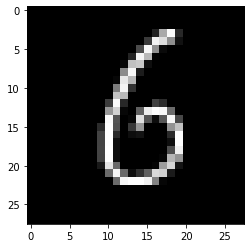

In [ ]:
plt.imshow(data[18][0].squeeze(), cmap='gray')